In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar
import warnings

warnings.filterwarnings("ignore")

# PUNTO 1

In [39]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

Creando una serie con los datos mensuales historicos y sus valores de fin de mes, iniciando desde 1991-12-31 hasta 2018-12-31.

In [40]:
base_trm = pd.read_csv("Tasa_de_Cambio_Representativa_del_Mercado-_TRM.csv", 
                       index_col="VIGENCIADESDE", usecols=[0,2], dtype= {"VALOR": np.float64},
                       parse_dates=True, dayfirst=True)
base_trm.index.names = ['FECHA']

valor_trm = base_trm.resample(rule='M').last()

startdate = pd.to_datetime('1991-12-31').date()

valor_trm.index = valor_trm.index.date

enddate = pd.to_datetime('2018-12-31').date()

valor = valor_trm.loc[:enddate]
valor.index = pd.to_datetime(valor.index)

Para elegir dos modelos ARIMA para realizar pronosticos sobre la serie se buscan aquellos modelos que minimicen los criterios de información de AIC y BIC. 

In [41]:
model = auto_arima(valor, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      d=None,           # not first difference
                      start_P=0,        # AR portion of seasonal model
                      D=1,              # seasonal differencing 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # use the stepwise algorithm
model.summary()

model2 = auto_arima(valor, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      d=None,           # not first difference
                      start_P=0,        # AR portion of seasonal model
                      D=1,              # seasonal differencing 
                      information_criterion = "bic",
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # use the stepwise algorithm
model2.summary()

#ARIMA (0,1,0) with aic and bic
#ARIMA (1,1,0) with aic and bic

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3733.257, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3730.784, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3731.263, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3731.312, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3732.413, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.602 seconds
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=3748.380, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=3738.346, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=3742.605, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=3742.654, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=3736.194, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.625 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  325
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1865.207
Date:                Sat, 21 Nov 2020   AIC                           3732.413
Time:                        14:38:39   BIC                           3736.194
Sample:                             0   HQIC                          3733.922
                                - 325                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5859.0617    307.603     19.047      0.000    5256.171    6461.953
===================================================================================
Ljung-Box (Q):                       79.30   Jarque-Bera (JB):                83.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.01   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Para realizar los pronósticos hasta septiembre de 2019, por medio de un rolling window, fijamos una ventana de tiempo que adicionará una observación mientras se elimina la primera de la muestra, hasta llegar a la fecha deseada de pronóstico.

In [42]:
#Fijamos fecha inicial de la predicción y fecha final
predstart = pd.to_datetime('2019-01-31').date()
preddate = pd.to_datetime('2019-09-30').date()

inter_pred = valor_trm.loc[predstart:preddate]
inter_pred.index.names = ["FECHA"]

#Base actual hasta la fecha en la que se hará la predicción
valor_pred = valor_trm.loc[:preddate]
valor_pred.index.names = ["FECHA"]

#Función para adicionar los meses a la muestra de pronóstico
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)
    
valor_pred.index = pd.to_datetime(valor_pred.index)

Pronosticando con ARIMA(0,1,0) y ARIMA (1,1,0)

In [43]:
valor_010 = valor

startnew = startdate
endnew = enddate

predictions1 = []
for t in range(9):
    arima_010 = ARIMA(valor_010, order=(0,1,0))
    model_fit = arima_010.fit(disp=0)
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions1.append(yhat)
    startnew = add_months(startnew, 1)
    endnew = add_months(endnew, 1)
    valor_010 = valor_trm.loc[startnew:endnew]

valor_010.index.names = ["FECHA"]

pred_010 = pd.DataFrame(predictions1, index = inter_pred.index, columns=["VALOR"])

In [44]:
valor_110 = valor

startnew = startdate
endnew = enddate

predictions2 = []
for t in range(9):
    arima_110 = ARIMA(valor_110, order=(1,1,0))
    model_fit = arima_110.fit(disp=0)
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions2.append(yhat)
    startnew = add_months(startnew, 1)
    endnew = add_months(endnew, 1)
    valor_110 = valor_trm.loc[startnew:endnew]
    
valor_110 = pd.DataFrame(valor_110, index = valor_pred.index, columns=["VALOR"])
valor_110.index.names = ["FECHA"]

pred_110 = pd.DataFrame(predictions2, index = inter_pred.index, columns=["VALOR"])

Resultado de pronóstico con ARIMA(0,1,0)

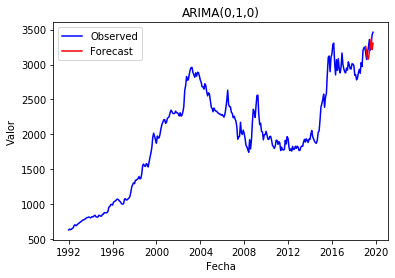

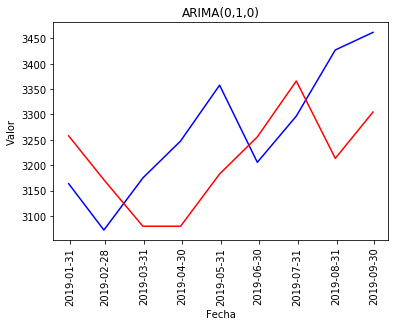

In [15]:
fig, ax = plt.subplots()

ax.plot(valor_pred.index, valor_pred["VALOR"], color = "blue", label = "Observed")
ax.plot(pred_010.index, pred_010["VALOR"], color = "red", label = "Forecast")

ax.set_xlabel("Fecha")
ax.set_ylabel("Valor")
ax.set_title("ARIMA(0,1,0)")

plt.legend(loc='best')

plt.show()

fig, ax = plt.subplots()

ax.plot(inter_pred.index, inter_pred["VALOR"], color = "blue", label = "Observed")
ax.plot(pred_010.index, pred_010["VALOR"], color = "red", label = "Forecast")

ax.set_xlabel("Fecha")
ax.set_ylabel("Valor")
ax.set_title("ARIMA(0,1,0)")
ax.set_xticklabels(pred_010.index, rotation=90)

plt.show()

Resultado de pronóstico con ARIMA(1,1,0)

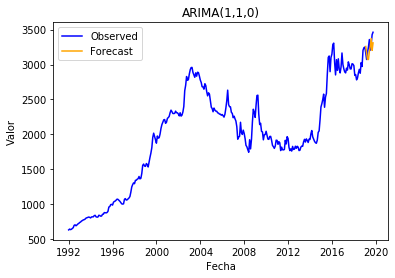

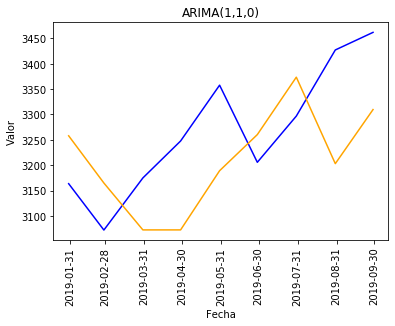

In [11]:
fig, ax = plt.subplots()

ax.plot(valor_pred.index, valor_pred["VALOR"], color = "blue", label = "Observed")
ax.plot(pred_110.index, pred_110["VALOR"], color = "orange", label = "Forecast")

ax.set_xlabel("Fecha")
ax.set_ylabel("Valor")
ax.set_title("ARIMA(1,1,0)")

plt.legend(loc='best')

plt.show()

fig, ax = plt.subplots()

ax.plot(inter_pred.index, inter_pred["VALOR"], color = "blue", label = "Observed")
ax.plot(pred_110.index, pred_110["VALOR"], color = "orange", label = "Forecast")

ax.set_xlabel("Fecha")
ax.set_ylabel("Valor")
ax.set_title("ARIMA(1,1,0)")
ax.set_xticklabels(pred_110.index, rotation=90)

plt.show()

## Diebold-Mariano Test

In [17]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

Realizamos el test de Diebold-Mariano que tiene como hipotesis nula una precisión predictiva igual para ambos modelos, teniendo como resultado una función de perdida igual a 0.

In [18]:
mad = dm_test(inter_pred["VALOR"], pred_010["VALOR"], pred_110["VALOR"], crit="MAD")
print(mad)
mse = dm_test(inter_pred["VALOR"], pred_010["VALOR"], pred_110["VALOR"], crit="MSE")
print(mse)

dm_return(DM=-0.9749151057177877, p_value=0.3581560054650574)
dm_return(DM=-0.8081549532460549, p_value=0.4423676506987019)


Como es posible ver el p valor es mayor a 0.05 tanto para la medida del Mean Square Error como para Mean Absolute Deviation, lo que significa que con un nivel de confianza del 95% la hipotesis nula no es rechazada, por lo que se puede concluir que ambas predicciones son equivalentes en precisión.

# PUNTO 2

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -7186.84
Distribution:                  Normal   AIC:                           14381.7
Method:            Maximum Likelihood   BIC:                           14407.2
                                        No. Observations:                 4412
Date:                Sat, Nov 21 2020   Df Residuals:                     4408
Time:                        14:39:46   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0505  1.642e-02      3.078  2.086e-03 [1.

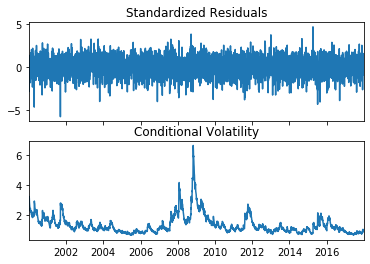

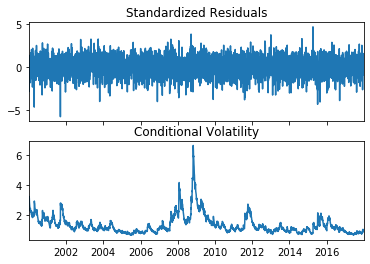

In [45]:
from arch import arch_model

base_indices = pd.read_csv("oxfordmanrealizedvolatilityindices.csv",
                       index_col=0, parse_dates=True, usecols = [0, 1, 6, 15])
base_indices.index = pd.to_datetime(base_indices.index, utc=True)

hsi = base_indices["Symbol"] == ".HSI"

base_hsi = base_indices[hsi]
base_hsi["returns"] = np.log(base_hsi["close_price"]).diff(periods=1)*100

base_hsi = base_hsi.dropna()

enddate = pd.to_datetime('2017-12-29').date()

hsi_2017 = base_hsi.loc[:enddate]

hsi_2017 = hsi_2017.dropna()

garch_hsi = arch_model(hsi_2017['returns'], p = 1, q = 1, mean = 'constant', 
                       vol = 'GARCH', dist = 'normal')
garch_fit = garch_hsi.fit(disp='off')

print(garch_fit.summary())

garch_fit.plot()

Construimos un EWMA que inicia en 2017 y pronostica la varianza en adelante, hasta la base de la fecha 11 de noviembre de 2020.

In [25]:
from arch.univariate import EWMAVariance, ZeroMean

hsi_returns = ZeroMean(base_hsi["returns"])

hsi_returns_vol = EWMAVariance(0.95)

ewma = hsi_returns.fit()

ewma_prediction = np.sqrt(ewma.forecast(horizon=1, start="2017-12-29").variance['2017-12-29':])*np.sqrt(252)

Era necesario definir un GARCH(1,1) con la muestra hasta septiembre de 2019, al que se le hará fit por medio de rolling window, adicionando una observación mientras se elimina la inicial, iniciando en enero de 2018 hasta septiembre del 2019.

In [28]:
returns_2017 = hsi_2017["returns"]

preddate = '2019-08-30'

pred_base = base_hsi["returns"].loc[:preddate]

inter_pred = base_hsi["returns"].loc['2018-01-01':preddate]

pred_garch = arch_model(pred_base, p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'normal')

start_base = '2000-01-04'
end_base = '2017-12-29'

start_loc = int(np.where(base_hsi.index == '2000-01-04')[0])
end_loc = int(np.where(base_hsi.index == '2017-12-29')[0])

forecasts = {}
for i in range(len(inter_pred)):
    gm_result = pred_garch.fit(first_obs = i + start_loc, 
                               last_obs = i + end_loc, update_freq = 5, disp='off')
    temp_result = gm_result.forecast(horizon = 1).variance
    fcast = temp_result.iloc[i + end_loc]
    forecasts[fcast.name] = fcast

forecast_var = pd.DataFrame(forecasts).T

inter_pred.index = inter_pred.index.date

Comparando el pronóstico con lo observado, vemos que:

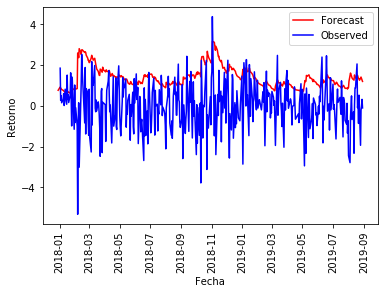

In [29]:
plt.plot(forecast_var, color = 'red', label = "Forecast")
plt.plot(inter_pred, color = 'blue', label = "Observed")

plt.xlabel("Fecha")
plt.ylabel("Retorno")
plt.xticks(rotation=90)

plt.legend(loc="best")

plt.show()

Evaluando por medio de Mean Square Error el desempeño del pronóstico es posible ver que se tiene una función de perdida de 3.5963

In [32]:
#MSE

from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(inter_pred, forecast_var)

print(MSE)

3.596383325929547
